# Image Classification

## Data Loading

In [ ]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation, tensor conversion and normalization for training
# Just normalization and tensor conversion for testing, validating
data_transforms = {
    'train': transforms.Compose([
      transforms.RandomCrop(32, padding=4), 
      transforms.RandomHorizontalFlip(), 
			transforms.ToTensor(), 
      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),

    ]),
    'test': transforms.Compose([
     transforms.ToTensor(), 
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),

    ]),
    'valid': transforms.Compose([
     transforms.ToTensor(), 
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])
}

# Load CIFAR10
torch.random.manual_seed(0)
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}

# Creating Validation Set
train, valid = random_split(image_datasets['train'],[40000,10000])
class_names = image_datasets['train'].classes

image_datasets['train'] = train
image_datasets['valid'] = valid

# Creating dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=(x=='train'), num_workers=2) for x in ['train', 'test', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','valid']}

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.9.0+cu102
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset_sizes

{'test': 10000, 'train': 40000, 'valid': 10000}

### Visualize a few images

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

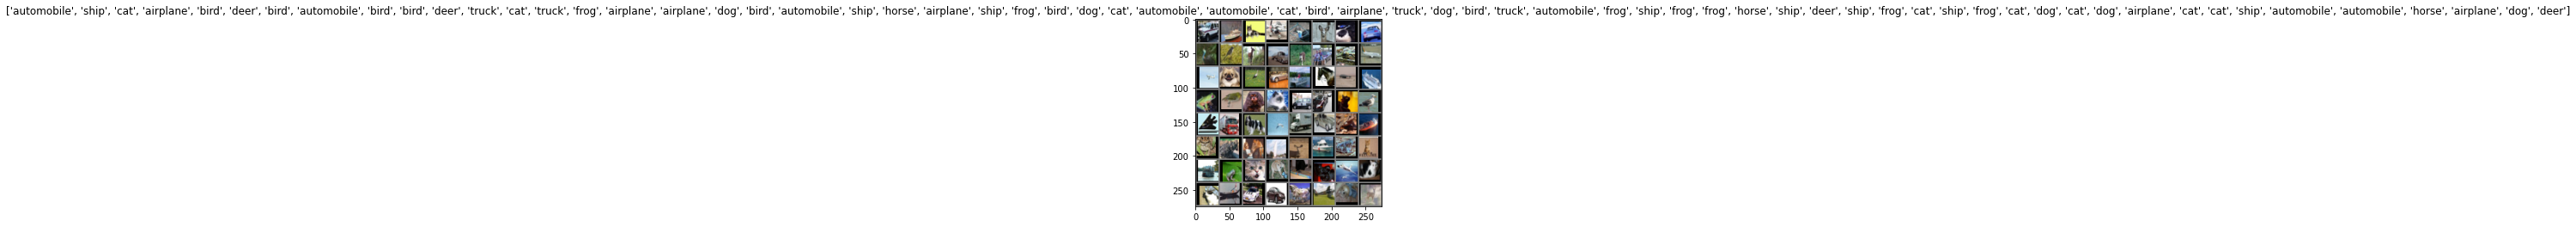

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Basic Networks

### Model training code 

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    losses = {
        'train': [],
        'valid': []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train': model.train()  # Set model to training mode
            if phase == 'valid': model.eval()  # Set model to evaluation  mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model, losses

### Model test code 

In [ ]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

### 1) FC Network

In [ ]:
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 400)
        self.fc3 = nn.Linear(400, 84)
        self.fc4 = nn.Linear(84, 10)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x))
        return x

model_ft = FcNet() #Define the model
model_ft = model_ft.to(device) 
print(model_ft)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion, optimizer, num_epochs=3)
test_model(model_ft)

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/2
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train Loss: 2.2349 Acc: 0.1868
Epoch 1/2
----------
train Loss: 2.0178 Acc: 0.2699
Epoch 2/2
----------
train Loss: 1.9040 Acc: 0.3134

Training complete in 0m 57s
test Acc: 0.3550
Testing complete in 0m 2s


### 2) CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet() #Define the model
model_ft = model_ft.to(device)
print(model_ft)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion, optimizer, num_epochs=3)
test_model(model_ft)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/2
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.8086 Acc: 0.3260
Epoch 1/2
----------
train Loss: 1.4878 Acc: 0.4580
Epoch 2/2
----------
train Loss: 1.3810 Acc: 0.5036

Training complete in 4m 18s
test Acc: 0.5602
Testing complete in 0m 10s


## ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, numBlocks, drop=False, drop_p=0.1):
        super(ResNet, self).__init__()

        self.numBlocks = numBlocks
        self.drop = drop
        self.feature_map1 = 0
        self.feature_map2 = 0

        # First Conv Layer
        self.Conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(16),
        )

        ## Layers''First Blocks, downsampling except L1
        self.L1_B1 = self._make_block(16, 16)

        self.L2_B1 = self._make_block(16, 32, downsample=True)
        self.L2_skip = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(32),
        )

        self.L3_B1 = self._make_block(32, 64, downsample=True)
        self.L3_skip = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(64),
        )

        ## Layers' Second Blocks, No downsampling
        if self.numBlocks >= 2: 
            self.L1_B2 = self._make_block(16, 16)
            self.L2_B2 = self._make_block(32, 32)
            self.L3_B2 = self._make_block(64, 64)

        ## Layers' Third Blocks, No downsampling
        if self.numBlocks >= 3: 
            self.L1_B3 = self._make_block(16, 16)
            self.L2_B3 = self._make_block(32, 32)
            self.L3_B3 = self._make_block(64, 64)

        # Final AvgPool and FC layer
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64, 10)

        # Dropout
        if self.drop == True:
            self.dropout = nn.Dropout(p=drop_p)


    def _make_block(self, in_channels, out_channels, downsample=False):
        
        # Set stride to 2 if downsampling required
        if downsample == True:
          s = 2
        else: s = 1

        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=s, padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(out_channels)
        )

        return block
    

    def forward(self, x):

        # First Conv, outputs # 32 x 32 x 16
        x = F.relu(self.Conv(x))

        self.feature_map1 = x

        # Layer 1, outputs # 32 x 32 x 16
        y = self.L1_B1(x)
        x = F.relu(x + y)  

        if self.numBlocks >= 2: 
            y = self.L1_B2(x)
            x = F.relu(x + y) 

        if self.numBlocks >= 3: 
            y = self.L1_B3(x)
            x = F.relu(x + y) 

        # Layer 2, outputs # 16 x 16 x 32
        residual = self.L2_skip(x)
        y = self.L2_B1(x)  
        x = F.relu(y + residual)

        if self.numBlocks >= 2: 
            y = self.L2_B2(x)
            x = F.relu(x + y) 

        if self.numBlocks >= 3: 
            y = self.L2_B3(x)
            x = F.relu(x + y) 
        

        # Layer 3, outputs # 8 x 8 x 64
        residual = self.L3_skip(x)
        y = self.L3_B1(x)  
        x = F.relu(y + residual)

        if self.numBlocks >= 2: 
            y = self.L3_B2(x)
            x = F.relu(x + y) 

        if self.numBlocks >= 3: 
            y = self.L3_B3(x)
            x = F.relu(x + y) 
        
        self.feature_map2 = x

        # Avg pool and final FC layer
        x = self.avgpool(x)  # 1x1x64
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # Optional dropout
        if self.drop == True: 
          x = self.dropout(x)

        return x

In [ ]:
RN_1Block = ResNet(numBlocks=1) #Define the model
RN_1Block = RN_1Block.to(device) 
print(RN_1Block)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_1Block.parameters(), lr=0.001, momentum=0.9)
train_model(RN_1Block, criterion, optimizer, num_epochs=25, save_path='RN_1Block.pth')
test_model(RN_1Block, load_path='RN_1Block.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_1Block_drop = ResNet(numBlocks=1, drop=True) #Define the model
RN_1Block_drop = RN_1Block_drop.to(device) 
print(RN_1Block_drop)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_1Block_drop.parameters(), lr=0.001, momentum=0.9)
train_model(RN_1Block_drop, criterion, optimizer, num_epochs=25, save_path='RN_1Block_drop.pth')
test_model(RN_1Block_drop, load_path='RN_1Block_drop.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_2Block = ResNet(numBlocks=2) #Define the model
RN_2Block = RN_2Block.to(device) 
print(RN_2Block)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_2Block.parameters(), lr=0.001, momentum=0.9)
train_model(RN_2Block, criterion, optimizer, num_epochs=25, save_path='RN_2Block.pth')
test_model(RN_2Block, load_path='RN_2Block.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_2Block_drop = ResNet(numBlocks=2, drop=True) #Define the model
RN_2Block_drop = RN_2Block_drop.to(device) 
print(RN_2Block_drop)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_2Block_drop.parameters(), lr=0.001, momentum=0.9)
train_model(RN_2Block_drop, criterion, optimizer, num_epochs=25, save_path='RN_2Block_drop.pth')
test_model(RN_2Block_drop, load_path='RN_2Block_drop.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_3Block = ResNet(numBlocks=3) #Define the model
RN_3Block = RN_3Block.to(device) 
print(RN_3Block)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_3Block.parameters(), lr=0.001, momentum=0.9)
train_model(RN_3Block, criterion, optimizer, num_epochs=25, save_path='RN_3Block.pth')
test_model(RN_3Block, load_path='RN_3Block.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_3Block_drop = ResNet(numBlocks=3, drop=True) #Define the model
RN_3Block_drop = RN_3Block_drop.to(device) 
print(RN_3Block_drop)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_3Block_drop.parameters(), lr=0.001, momentum=0.9)
train_model(RN_3Block_drop, criterion, optimizer, num_epochs=25, save_path='RN_3Block_drop.pth')
test_model(RN_3Block_drop, load_path='RN_3Block_drop.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_3Block_drop2 = ResNet(numBlocks=3, drop=True, drop_p=0.2) #Define the model
RN_3Block_drop2 = RN_3Block_drop2.to(device) 
print(RN_3Block_drop2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_3Block_drop2.parameters(), lr=0.001, momentum=0.9)
train_model(RN_3Block_drop2, criterion, optimizer, num_epochs=25, save_path='RN_3Block_drop2.pth')
test_model(RN_3Block_drop2, load_path='RN_3Block_drop2.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [ ]:
RN_3Block_drop3 = ResNet(numBlocks=3, drop=True, drop_p=0.5) #Define the model
RN_3Block_drop3 = RN_3Block_drop3.to(device) 
print(RN_3Block_drop3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(RN_3Block_drop3.parameters(), lr=0.001, momentum=0.9)
train_model(RN_3Block_drop3, criterion, optimizer, num_epochs=25, save_path='RN_3Block_drop3.pth')
test_model(RN_3Block_drop3, load_path='RN_3Block_drop3.pth')

ResNet(
  (Conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L1_B1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (L2_B1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

## Optimizer and lr experiments

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TRAINING USING SGD WITH LEARNING RATE 0.1
Epoch 0/24
----------
train Loss: 1.5897 Acc: 0.4038
valid Loss: 1.3093 Acc: 0.5375
Epoch 1/24
----------
train Loss: 1.0846 Acc: 0.6113
valid Loss: 1.1351 Acc: 0.6029
Epoch 2/24
----------
train Loss: 0.8994 Acc: 0.6788
valid Loss: 1.1676 Acc: 0.6059
Epoch 3/24
----------
train Loss: 0.7901 Acc: 0.7244
valid Loss: 0.8458 Acc: 0.7058
Epoch 4/24
----------
train Loss: 0.7025 Acc: 0.7541
valid Loss: 0.8007 Acc: 0.7293
Epoch 5/24
----------
train Loss: 0.6456 Acc: 0.7754
valid Loss: 0.7551 Acc: 0.7441
Epoch 6/24
----------
train Loss: 0.5997 Acc: 0.7923
valid Loss: 0.6798 Acc: 0.7646
Epoch 7/24
----------
train Loss: 0.5625 Acc: 0.8048
valid Loss: 0.6253 Acc: 0.7890
Epoch 8/24
----------
train Loss: 0.5321 Acc: 0.8178
valid Loss: 0.6735 Acc: 0.7699
Epoch 9/24
----------
train Loss: 0.5033 Acc: 0.8261
valid Loss: 0.6086 Acc: 0.7931
Epoch 10/24
----------
train Loss: 0.4820 A

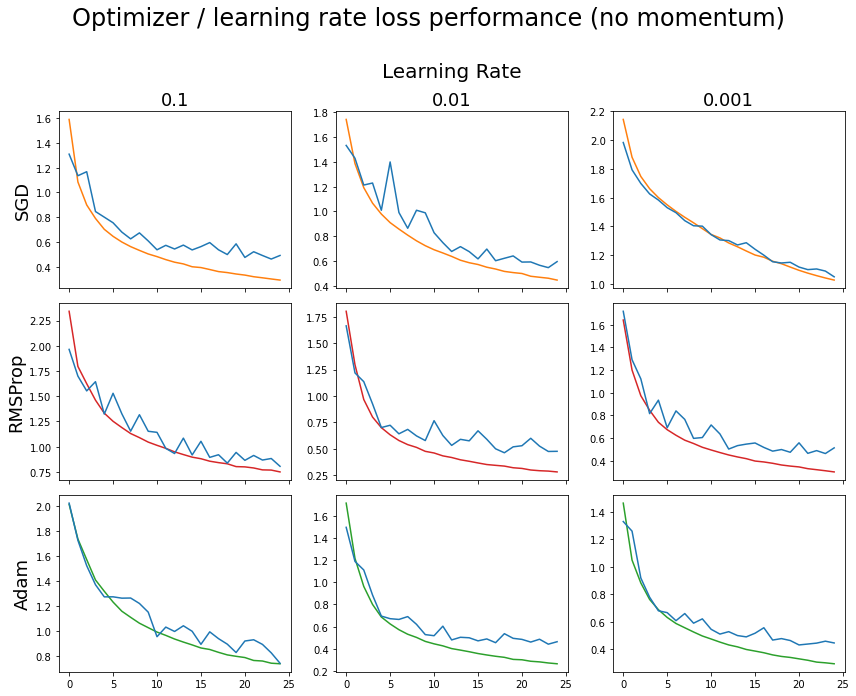

In [ ]:
def get_opt(model, learningR):
    sgd = optim.SGD(model.parameters(), lr=learningR)
    rms = optim.RMSprop(model.parameters(), lr=learningR)
    adam = optim.Adam(model.parameters(), lr=learningR)
    opts = [sgd, rms, adam]
    return opts

optimLosses = []
learningRates = [0.1, 0.01, 0.001]

OPTS = ["SGD", "RMSProp", "Adam"]

for choose_opt in range(len(OPTS)):
    for lr in learningRates:
        
        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        print("TRAINING USING " + OPTS[choose_opt] + " WITH LEARNING RATE " + str(lr))
        print("==================================================================================================")

        model_ft = ResNet(numBlocks=3)
        model_ft = model_ft.to(device)
        criterion = nn.CrossEntropyLoss()

        optimizerList = get_opt(model_ft, lr)
        optimizer = optimizerList[choose_opt]

        _, losses = train_model(model_ft, criterion, optimizer, num_epochs=25)  #10 epochs due to time restraints
        test_model(model_ft)

        optimLosses.append(losses)


fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 9))

axs[0, 0].plot(optimLosses[0]['train'], 'tab:orange')
axs[0, 0].plot(optimLosses[0]['valid'], 'tab:blue')

axs[0, 1].plot(optimLosses[1]['train'], 'tab:orange')
axs[0, 1].plot(optimLosses[1]['valid'], 'tab:blue')


axs[0, 2].plot(optimLosses[2]['train'], 'tab:orange')
axs[0, 2].plot(optimLosses[2]['valid'], 'tab:blue')


axs[1, 0].plot(optimLosses[3]['train'], 'tab:red')
axs[1, 0].plot(optimLosses[3]['valid'], 'tab:blue')


axs[1, 1].plot(optimLosses[4]['train'], 'tab:red')
axs[1, 1].plot(optimLosses[4]['valid'], 'tab:blue')


axs[1, 2].plot(optimLosses[5]['train'], 'tab:red')
axs[1, 2].plot(optimLosses[5]['valid'], 'tab:blue')


axs[2, 0].plot(optimLosses[6]['train'], 'tab:green')
axs[2, 0].plot(optimLosses[6]['valid'], 'tab:blue')



axs[2, 1].plot(optimLosses[7]['train'], 'tab:green')
axs[2, 1].plot(optimLosses[7]['valid'], 'tab:blue')


axs[2, 2].plot(optimLosses[8]['train'], 'tab:green')
axs[2, 2].plot(optimLosses[8]['valid'], 'tab:blue')


for ax, ve in zip(axs[0], [0.1, 0.01, 0.001]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axs[:, 0], ['SGD', 'RMSProp', 'Adam']):
    ax.set_ylabel(mode, size=18)
    

axs[0, 1].annotate('Learning Rate', (0.5, 1), xytext=(0, 30),
                   textcoords='offset points', xycoords='axes fraction',
                   ha='center', va='bottom', size=20)


fig.suptitle('Optimizer / learning rate loss performance (no momentum)', y=1.07, fontsize=24)
fig.tight_layout()
      

### Display model predictions

In [ ]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

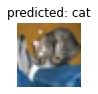

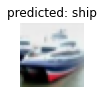

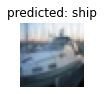

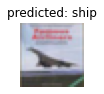

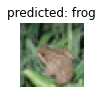

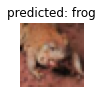

In [ ]:
# Diplay your best model predictions
display_predictions(RN_3Block)

## Visualizing activations

In [ ]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [ ]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg') # Loads an image and normalizes it
RN_3Block.eval()
with torch.no_grad():
    RN_3Block(inputs)
    feature_map1 = RN_3Block.feature_map1.transpose(1,0).cpu()
    feature_map2 = RN_3Block.feature_map2.transpose(1,0).cpu()

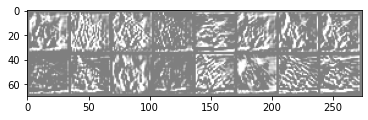

In [ ]:
# Visualize the feature maps
out = torchvision.utils.make_grid(feature_map1)
feature_imshow(out)

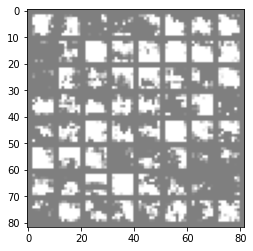

In [ ]:
out = torchvision.utils.make_grid(feature_map2)
feature_imshow(out)